# Nutrient (N, P, Fe) distribution

Here I plot the nutrients N, P, and Fe that were simulated by the Darwin global model (Dutkiewicz et al., 2019).

I calculate the nutrient supply ratios phi(P:N) (1) and phi(Fe:N) (2), which are used to describe the excess P and Fe supply. These are the ratio of the gross delivery rate of phosphorus and iron, relative to the gross delivery rate of bioavailable nitrogen, normalized by estimated P:N or Fe:N ratio of nondiazotrophic phytoplankton community (Ward et al., 2013).

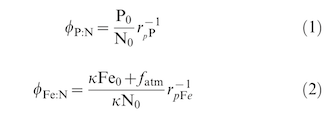

Based on Ward et al. (2013) Web Appendix, I included only components that add dissolved nitrogen, phosphate, or iron to the model surface 100m.\
Assumptions:

- Integrate over top 100m (= 6th depth level of model)
- Sum up transport terms and remineralization terms; iron dust deposition is included in Nutr['gGUD07']

#### Load requirements and set switches

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [17]:
#Load data

# model simulation output
Nutr = xr.open_dataset('/Users/meilers/MITinternship/Data/Nutr_tend.0000014400.nc')
grid = xr.open_dataset('/Users/meilers/MITinternship/Data/supply50m.nc')

# iron dust flux
fein = np.fromfile('/Users/meilers/MITinternship/Data/mahowald2009_solubile_current_smooth_oce_mth-2d.bin', '>f4').reshape(12,160,360)

lon1 = grid.lon   #needed for plotting
lat1 = grid.lat    #needed for plotting

# transport terms
NO3 = Nutr['gTr04']
PO4 = Nutr['gTr05']
FeT = Nutr['gTr07']

# other terms: remineralization and dust in case of Fe
NO3_o = Nutr['gGUD04']
PO4_o = Nutr['gGUD05']
FeT_o = Nutr['gGUD07']

sec = 31557600  #seconds per year (365.25*86400)
depth = 6 #RF = 0, -10, -20, -35, -55, -75, -100, -135, -185, (...)

NO3_trans = np.sum(NO3[0,0:depth,:,:],axis=0)*sec
PO4_trans = np.sum(PO4[0,0:depth,:,:],axis=0)*sec
FeT_trans = np.sum(FeT[0,0:depth,:,:],axis=0)*sec

NO3_other = np.sum(NO3_o[0,0:depth,:,:],axis=0)*sec
PO4_other = np.sum(PO4_o[0,0:depth,:,:],axis=0)*sec
FeT_other = np.sum(FeT_o[0,0:depth,:,:],axis=0)*sec

f_dust = np.sum(fein,axis=0)*sec

N = np.add(NO3_trans,NO3_other)
P = np.add(PO4_trans,PO4_other)
Fe = np.add(FeT_trans,FeT_other)

Calculate ratios:

In [18]:
# Bioavailable nutrient supply --> bio_PN, bio_FeN
# Constants
rpP = 0.0625
rpFe = 6.25e-5
k = 0.1

#bio_PN = (np.divide(P,N))*(1/rpP)
#bio_FeN = (np.divide(Fe,N))*(1/rpFe)

bio_PN = (np.divide(PO4_trans,NO3_trans))*(1/rpP)
F = np.add((FeT_trans*k),f_dust)
bio_FeN = (np.divide(F,(NO3_trans*k)))*(1/rpFe)

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: invalid value encountered in true_divide
  result_data = func(*input_data)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)
/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: invalid value encountered in true_divide
  result_data = func(*input_data)


Note: to calculate the phi(Fe:N) and phi(P:N) I only used the transport fluxes (no remineralization). For iron, I added the dust source given from the Mahowald 2009 data (Steph's big binary file).

Plot the nutrient ratios:

/opt/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/opt/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linstyle'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


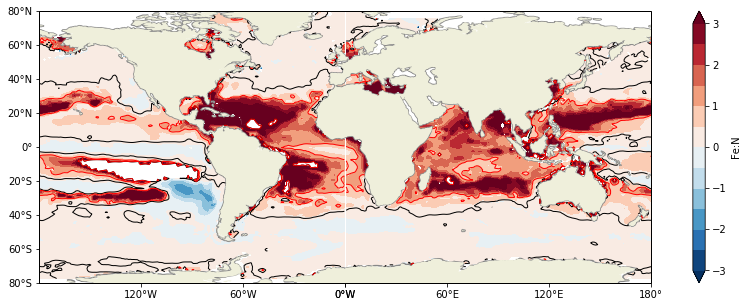

In [19]:
nut = 1    #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN,bio_FeN]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
c = ax.contourf(lon1,lat1,np.log(nutrient[nut]),levels=levs[nut],cmap=colmap,extend='both')
con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
con2 = ax.contour(lon1,lat1,nutrient[nut],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()
#fig.savefig('/Users/meilers/MITinternship/Plots/overview_nutr_bioav_'+str(name_nut[nut])+'.png', bbox_inches='tight', dpi=300)

Compare to Ward et al., 2013:

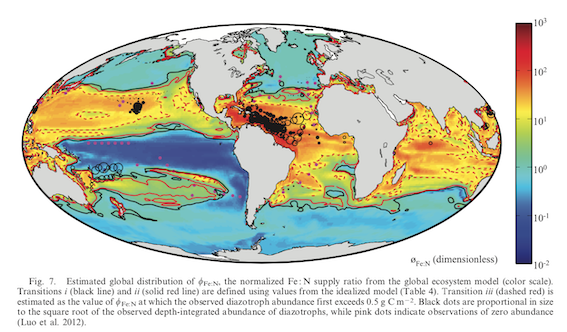

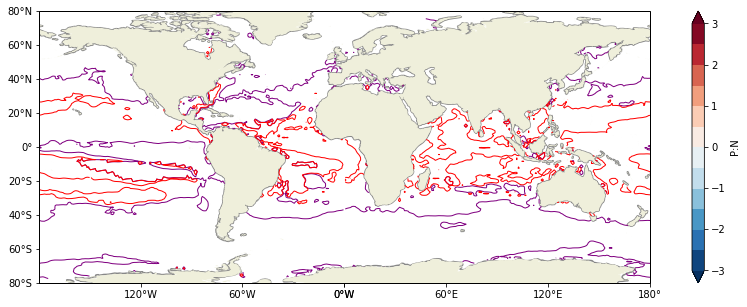

In [5]:
nut = 0    #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN,bio_FeN]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N']

levs_PN = np.linspace(2.5,3,2)
levs_FeN = np.linspace(0,200,11)
levs = [levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
#c = ax.imshow(lon1,lat1,nutrient[nut],levels=levs[nut],cmap=colmap,extend='max')
con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.04],colors='purple',linewidths=1,linstyle='solid')
con2 = ax.contour(lon1,lat1,nutrient[nut],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()
#fig.savefig('/Users/meilers/MITinternship/Plots/overview_nutr_bioav_'+str(name_nut[nut])+'.png', bbox_inches='tight', dpi=300)

Compare to Ward et al., 2013:

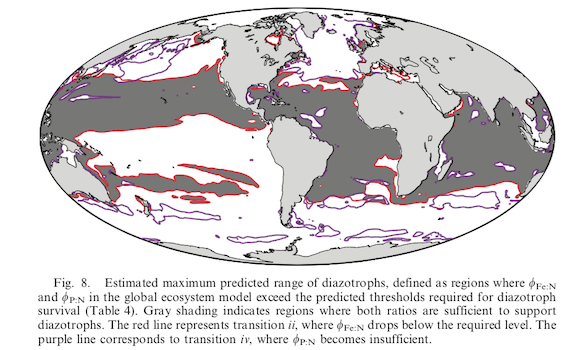

As a comparison, I'll do the same plots for the data Greg gave me.

In [6]:
data10 = xr.open_dataset('/Users/meilers/MITinternship/Data/supply10m.nc')
data50 = xr.open_dataset('/Users/meilers/MITinternship/Data/supply50m.nc')
data100 = xr.open_dataset('/Users/meilers/MITinternship/Data/supply100m.nc')

At 50 m depth:

In [7]:
# transport terms
NO3 = data50.transN
PO4 = data50.transP
FeT = data50.transFe

# other terms: remineralization and dust in case of Fe
NO3_o = data50.otherSN
PO4_o = data50.otherSP
FeT_o = data50.otherSFe

In [8]:
N_2D = NO3*sec
P_2D = PO4*sec
Fe_2D = FeT*sec#,f_dust) #including dust

bio_PN_2D = (np.divide(P_2D,N_2D))*(1/rpP)
Fe_tot = np.add((Fe_2D*k),f_dust)
bio_FeN_2D = (np.divide(Fe_tot,(N_2D*k)))*(1/rpFe)

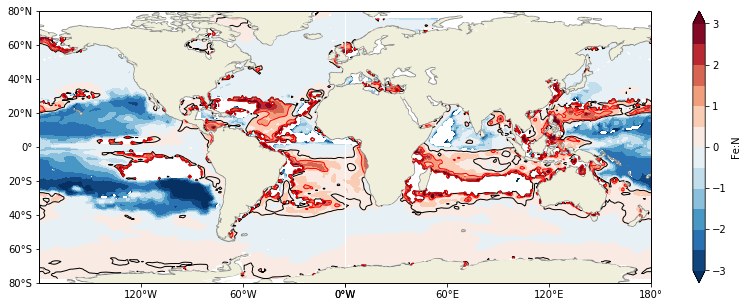

In [9]:
nut = 1    #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN_2D,bio_FeN_2D]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
c = ax.contourf(lon1,lat1,np.log(nutrient[nut]),levels=levs[nut],cmap=colmap,extend='both')
con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
con2 = ax.contour(lon1,lat1,nutrient[nut],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()
#fig.savefig('/Users/meilers/MITinternship/Plots/overview_nutr_bioav_'+str(name_nut[nut])+'.png', bbox_inches='tight', dpi=300)

### Import diazotroph observational data

In [10]:
# Load diazotroph data
ds = Dataset('/Users/meilers/MITinternship/Data/MarEDat20130403Diazotrophs.nc', 'r')

# extract variables which are needed and convert/integrate
lon = ds.variables['LONGITUDE']
lat = ds.variables['LATITUDE']
#lon_new = lon[:] #in case I needed to modify the lon/lat to match it the lon/lat of the nutrients
#lat_new = lat[:]

obs = ds.variables['OBSERVATIONS']
abund = ds.variables['ABUNDANCE']

obs_int = np.sum(obs[:,0:6,:,:],axis=1)
abund_int = np.sum(abund[:,0:6,:,:],axis=1)

obs_tot = np.sum(obs_int,axis=0)
abund_tot = np.sum(abund_int,axis=0)

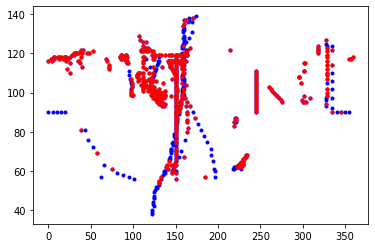

In [11]:
# Create a mask: 0 = absence, 1 = presence
        
mask1 = np.zeros_like(obs_tot)
mask1[obs_tot>0] = 1

mask2 = np.zeros_like(abund_tot)
mask2[abund_tot>0] = 1

find1 = np.where(mask1==1)
find2 = np.where(mask2==1)

plt.plot(find1[1],find1[0],'.',color='b')
plt.plot(find2[1],find2[0],'.',color='r')
plt.show()

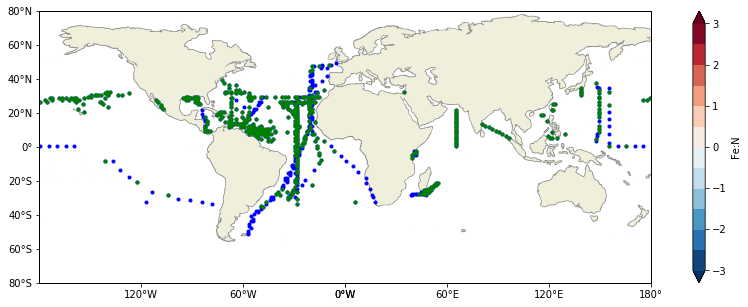

In [12]:
nut = 1    #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN,bio_FeN]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
#c = ax.contourf(lon1,lat1,np.log(nutrient[nut]),levels=levs[nut],cmap=colmap,extend='both')
#con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
#con2 = ax.contour(lon1,lat1,nutrient[nut],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
plt.plot(lon[find1[1]],lat[find1[0]],'.',color='b',label='obs')
plt.plot(lon[find2[1]],lat[find2[0]],'.',color='g',label='abund')
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()

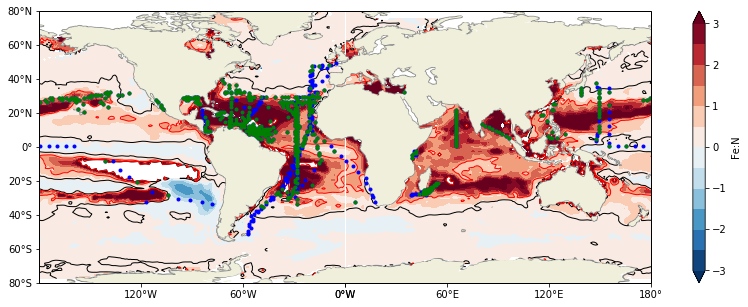

In [13]:
nut = 1    #chose nutrient here: 0=Fe, 1=N, 2=P
nutrient = [bio_PN,bio_FeN]
label_nut = ['N (mol/m$^{2}$/y)','P (mol/m$^{2}$/y)','Fe (mol/m$^{2}$/y)']
name_nut = ['P:N','Fe:N']

levs_PN = np.linspace(0,1000,11)
levs_FeN = np.linspace(-3,3,13)
levs = [levs_PN,levs_FeN]

colmap = plt.get_cmap('RdBu_r')

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,5))
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=cfeature.COLORS['land']))
c = ax.contourf(lon1,lat1,np.log(nutrient[nut]),levels=levs[nut],cmap=colmap,extend='both')
con1 = ax.contour(lon1,lat1,nutrient[nut],levels=[1.2],colors='k',linewidths=1,linstyle='solid')
con2 = ax.contour(lon1,lat1,nutrient[nut],levels=[2.5],colors='r',linewidths=1,linstyle='solid')
plt.plot(lon[find1[1]],lat[find1[0]],'.',color='b') #blue = observations
plt.plot(lon[find2[1]],lat[find2[0]],'.',color='g') #green = abundance
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
cbar = plt.colorbar(c,ax=ax)
cbar.set_label(''+str(name_nut[nut])+'',rotation=90, position=(0.5,0.5))
plt.show()